HW1
https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb#scrollTo=lOqcmYzMO7jB

In [121]:
tr_path = 'covid.train.csv'
tt_path = 'covid.test.csv'
!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 62.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 43.3MB/s]


In [122]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import csv
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(myseed)

In [123]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [124]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            pass

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [125]:
def prep_dataloader(path, mode, batch_size, n_jobs= 0, target_only= False):
  ''' Generate a dataset, then is put into a dataloader. '''
  dataset = COVID19Dataset(path, mode= mode, target_only= target_only)
  dataloader = DataLoader(dataset,
                          batch_size, 
                          shuffle=(mode== 'train'), 
                          drop_last= False, 
                          num_workers= n_jobs, 
                          pin_memory= True
                          )
  return dataloader

In [150]:
def train(tr_set, dv_set, model, config, device):
  ''' DNN training '''

  n_epochs = config['n_epochs']

  optimizer = getattr(torch.optim, config['optimizer'])(
      model.parameters(), **config['optim_hparas'])
  min_mse = 1000.
  loss_record = {'train': [], 'dev': []}
  early_stop_cnt= 0
  epoch = 0
  while epoch < n_epochs:
    model.train()
    for x, y in tr_set:
      optimizer.zero_grad()
      x, y = x.to(device), y.to(device)
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
      mse_loss.backward()
      optimizer.step()
      loss_record['train'].append(mse_loss.detach().cpu().item())

    dev_mse = dev(dv_set, model, device)
    if dev_mse < min_mse:
      min_mse = dev_mse
      print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch+ 1, min_mse))
      torch.save(model.state_dict(), config['save_path'])
      early_stop_cnt = 0
    else:
      early_stop_cnt += 1

    epoch += 1
    loss_record['dev'].append(dev_mse)
    if early_stop_cnt > config['early_stop']:
      break
  print('Finished training after {} epochs'.format(epoch))
  return min_mse, loss_record

In [128]:
  def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for x, y in dv_set:
      x, y = x.to(device), y.to(device)
      with torch.no_grad():
        pred = model(x)
        mse_loss = model.cal_loss(pred, y)
      total_loss += mse_loss.detach().cpu().item() * len(x)
    total_loss = total_loss /len(dv_set.dataset)

    return total_loss

In [129]:
def test(tt_set, model, device):
  model.eval()
  preds = []
  for x in tt_set:
    x = x.to(device)
    with torch.no_grad():
      pred = model(x)
      preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim= 0).numpy()
    return preds

In [130]:
device = get_device()
os.makedirs('models', exist_ok =True)
target_only = False

config = {
    'n_epochs':3000,
    'batch_size': 270,
    'optimizer' : 'SGD',
    'optim_hparas': {'lr': 0.001, 'momentum': 0.9}, 
    'early_stop': 200,
    'save_path': 'models/model.pth'
}

In [139]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only= target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only= target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only= target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [160]:
model = NeuralNet(tr_set.dataset.dim).to(device)

In [161]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 94.1784)
Saving model (epoch =    2, loss = 29.1898)
Saving model (epoch =    3, loss = 21.9438)
Saving model (epoch =    4, loss = 14.3114)
Saving model (epoch =    5, loss = 8.4488)
Saving model (epoch =    6, loss = 6.2595)
Saving model (epoch =    7, loss = 5.4753)
Saving model (epoch =    8, loss = 4.7129)
Saving model (epoch =    9, loss = 4.0483)
Saving model (epoch =   10, loss = 3.6252)
Saving model (epoch =   11, loss = 3.3153)
Saving model (epoch =   12, loss = 3.0538)
Saving model (epoch =   13, loss = 2.8586)
Saving model (epoch =   14, loss = 2.6504)
Saving model (epoch =   15, loss = 2.5222)
Saving model (epoch =   16, loss = 2.3525)
Saving model (epoch =   17, loss = 2.2326)
Saving model (epoch =   18, loss = 2.0705)
Saving model (epoch =   19, loss = 1.9746)
Saving model (epoch =   20, loss = 1.9328)
Saving model (epoch =   21, loss = 1.8078)
Saving model (epoch =   22, loss = 1.7451)
Saving model (epoch =   23, loss = 1.6769)
Saving 

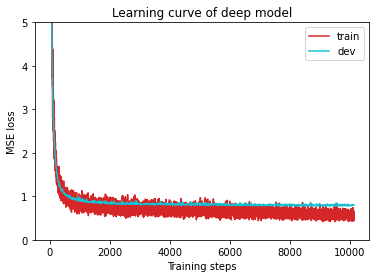

In [152]:
plot_learning_curve(model_loss_record, title= 'deep model')

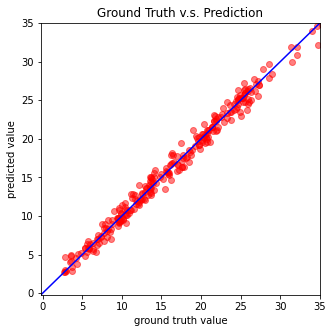

In [165]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location= 'cpu')
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)

In [166]:
def save_pred(preds, file):
  ''' Save predictions to specified file '''
  print('Saving results to {}'.format(file))
  with open(file, 'w') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'tested_positive'])
    for i, p in enumerate(preds):
      writer.writerow([i, p])

preds = test(tt_set, model, device)
save_pred(preds, 'pred.csv')

Saving results to pred.csv
